# Domain decomposition and the `DomDecOT.jl` library

This notebook is an introduction to the workings of the library `DomDecOT.jl` for solving (entropic) optimal transport problems with the domain decomposition algorithm. For a more direct approach applied to a 2D problem see notebook 2. If you are familiar with the domain decomposition algorithm you may skip the explanation below. 

## The domain decomposition algorithm

The domain decomposition method works by dividing the optimal transport problem into smaller problems, solving them independently and combining the partial solutions together. It is described and analysed in depth in this paper by Bonafini and Schmitzer: https://arxiv.org/abs/2001.10986. Under an appropriate choice of the subproblems, it converges linearly to the optimal solution. Thus it is amenable to parallelization and efficient.

For starting the domain decomposition algorithm we need


* Two probability measures, $\mu$ on $X$ and $\nu$ on $Y$.
* A sequence of subdomains of $X$, namely $(X_k)_k$ (usually organized into two _partitions_ of the domain $X$).
* An initial, feasible coupling $\pi_0\in \Pi(\mu, \nu)$.
* Some regularization parameter $\varepsilon\ge0$.
	
Then each iteration $k=1,2,...$ of the domain decomposition algorithm consists in the following steps
1. Get the partial marginals:
$$
\mu_k  \leftarrow \mu {\Large\llcorner}  X_k,
    \qquad 
    \nu_k \leftarrow \text{P}_Y(\pi^{k-1} {\Large\llcorner} (X_k \times Y)).
$$
where the operator ${\Large\llcorner} $ denotes the restriction of a measure to a set.
2. Solve the (entropic) OT problem for measures $\mu_k$ and $\nu_k$:
$$\tilde{\pi} \leftarrow \displaystyle \text{argmin}_{\pi \in \Pi(\mu_k, \nu_k)} \int_{X\times Y} c\text{d} \pi + \varepsilon \text{KL}(\pi | \mu\otimes \nu).$$
3. Update the global plan
$$\pi^k 
\leftarrow
\pi^{k-1} {\Large\llcorner} ( (X\backslash X_k) \times Y)
+
\tilde{\pi}$$
		
Naturally, if the subdomains $X_k, X_{k+1}$ are disjoint, their corresponding iterations can be performed in parallel; this allows for thorough parallelization. Besides, on the memory requirements part, we don't need to store the whole coupling, but just being able to compute $\nu_k$ on each iteration. This can be achieved very efficiently if we choose the subdomains $X_k$ in such a way that they are unions of some partition of $X$ called _basic cells_ $(\tilde{X}_i)_{i\in I}$. I.e., we impose that 

$$X_k = \bigcup_{j \in J_k} \tilde{X}_j$$ 
for certain subsets $J_k \subset I$. Then defining

$$\tilde{\nu}_{k,j} \leftarrow \text{P}_Y(\pi^{k} {\Large\llcorner} (\tilde{X}_j \times Y))\quad \text{for each }k, i$$
step 1. turns into
$$
\mu_k  \leftarrow \mu {\Large\llcorner}  X_k,
    \qquad 
    \nu_k \leftarrow \sum_{j\in J_k} \tilde{\nu}_{k,j}
$$

And so we only need to store the _basic cell marginals_ $\tilde{\nu}_{k,i}$. This allows for a great reduction in the algorithm memory requirements with respect to a sparse sinkhorn implementation, which makes it also very amenable to parallelization.

## The `DomDecOT.jl` library in a 1D example

This library follows closely the implementation given in https://arxiv.org/abs/2001.10986 for the domain decomposition algorithm. We store the state of the algorithm in a `DomDecPlan`; its inner workings will be reviewed now. First, let us define some measures on $X$ and $Y$, as well as a coupling.

In [1]:
import Pkg; Pkg.activate("."); Pkg.instantiate() # Activate environment

  Activating environment at `~/PhD/DomDec/DomDecOTExamples.jl/Project.toml`


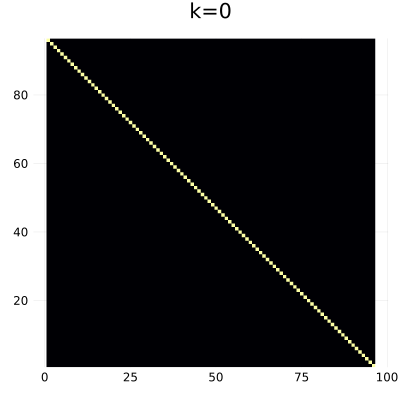

In [34]:
using DomDecOT
using MultiScaleOT
using Plots
gr()
default(size = (400, 400), legend = :none, aspect_ratio = :equal, showaxis = false)

function setup_domdec_flipped_three_cells(N)

    μ = ones(N); μ ./= sum(μ)
    x1 = collect(1.:N)./N
    X = flat_grid(x1)
    shapeX = (N,)
    
    # Setup the measures
    mu = GridMeasure(X, μ, shapeX)
    nu = deepcopy(mu)
    
    # This matrix corresponds to the "flipped" of an identity, as we will see in the plot
    plan0 = [(i==N+1-j)/N for j in 1:N, i in 1:N]
    return mu, nu, plan0
end
   
n = 32
mu, nu, plan0 = setup_domdec_flipped_three_cells(3*n)
p0 = heatmap(plan0, title = "k=0")
plot!()

For setting up a plan we give the $X$ marginal `mu`, the $Y$ marginal `nu`, an initial plan `plan0` (that can be a sparse or dense matrix, or a list of basic cell marginals, as explained above) and a _cellsize_, which is the size of the basic cells. In our case the domain $X$ has size `3n` and we give a cellsize of `n`, indicating that the domain will be divided into 3 chunks of size `n`.

In [19]:
P0 = DomDecPlan(mu, nu, plan0, n)

DomDecPlan with cellsize 32 and marginals
    mu: 1D GridMeasure with gridshape (96,)
    nu: 1D GridMeasure with gridshape (96,)

`P0.gamma` contains the basic cell marginals of the initial plan, in form of sparse vectors.

In [20]:
typeof(P0.gamma)

Vector{SparseArrays.SparseVector{Float64, Int64}} (alias for Array{SparseArrays.SparseVector{Float64, Int64}, 1})

In [21]:
P0.gamma[1]

96-element SparseArrays.SparseVector{Float64, Int64} with 32 stored entries:
  [65]  =  0.0104167
  [66]  =  0.0104167
  [67]  =  0.0104167
  [68]  =  0.0104167
  [69]  =  0.0104167
  [70]  =  0.0104167
  [71]  =  0.0104167
  [72]  =  0.0104167
  [73]  =  0.0104167
  [74]  =  0.0104167
        ⋮
  [86]  =  0.0104167
  [87]  =  0.0104167
  [88]  =  0.0104167
  [89]  =  0.0104167
  [90]  =  0.0104167
  [91]  =  0.0104167
  [92]  =  0.0104167
  [93]  =  0.0104167
  [94]  =  0.0104167
  [95]  =  0.0104167
  [96]  =  0.0104167

Basic cells can be accessed as `P0.basic_cells`. 

In [22]:
P0.basic_cells

3-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
 [33, 34, 35, 36, 37, 38, 39, 40, 41, 42  …  55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
 [65, 66, 67, 68, 69, 70, 71, 72, 73, 74  …  87, 88, 89, 90, 91, 92, 93, 94, 95, 96]

Composite cells are the `J_k` in the mathematical description above; they indicate which basic cells must be merged to obtain each of the subdomains.

In [23]:
P0.composite_cells

2-element Vector{Vector{Vector{Int64}}}:
 [[1, 2], [3]]
 [[1], [2, 3]]

For convenience, we also store the indices of the $X_J$ themselves, this is, the union of basic cells corresponding to each subdomain. 

In this case we have two partitions, one consisting in the subdomains `1:2n`, `2n+1:3n` and the other consisting in the subdomains `1:n, n+1:2n`. 

In [24]:
P0.partitions

2-element Vector{Vector{Vector{Int64}}}:
 [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  55, 56, 57, 58, 59, 60, 61, 62, 63, 64], [65, 66, 67, 68, 69, 70, 71, 72, 73, 74  …  87, 88, 89, 90, 91, 92, 93, 94, 95, 96]]
 [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  23, 24, 25, 26, 27, 28, 29, 30, 31, 32], [33, 34, 35, 36, 37, 38, 39, 40, 41, 42  …  87, 88, 89, 90, 91, 92, 93, 94, 95, 96]]

The standard way of solving the entropic problem will be to invoke the sinkhorn algorithm. Thus, we keep track of the dual variables in each of the subdomains of each partition.

In [25]:
P0.alphas

2-element Vector{Vector{Vector{Float64}}}:
 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [26]:
P0.betas

2-element Vector{Vector{Vector{Float64}}}:
 [[], []]
 [[], []]

Finally, we also keep track of which was the last iteration that was solve in the domain decomposition algorithm, as well as the value of $\varepsilon$ that was used. This will be useful for recovering the global plan.

In [27]:
P0.partk, P0.epsilon

(0, 1.0)

# Solving the problem

For solving the problem we need to set up a number of parameters. This is automatized when solving big problems (as shown in notebook 2.), but here we go a bit more on detail over them: 

In [28]:
c(x,y) = sum((x.-y).^2)                   # The squared cost, any other can be provided

params = (; epsilon = 0.001,              # Epsilon for the entropic problems
            solver_max_error = 1e-4,      # Max error for subproblem solver  
            solver_max_error_rel=true,    # Whether solver_max_error must be multiplied by the mass of the cell
            solver_max_iter = 10000,      # Max iters for subproblem solver
            solver_verbose = true,        # verbose mode for subproblem solver
            balance = true,               # Ensuring correctness on X marignals, see Section 6.2 of main paper
            truncate = true,              # Whether to truncate values to have sparse basic cell marginals
            truncate_Ythresh = 1e-15,     # Threshold for truncation
            truncate_Ythresh_rel = false # Whether the threshold must be multiplied by the mass of the cell
        );

solver = domdec_sinkhorn_stabilized!      # This is a fast, typically stable solver (if good duals are provided)
#solver = domdec_logsinkhorn!             # This is a slower, but stable solver

domdec_sinkhorn_stabilized! (generic function with 1 method)

Solve problem on the cells of the first partition and update the plan with their solutions

In [29]:
# Copy initialization
P = deepcopy(P0)
# Perform a first iteration
iterate_serial!(P, 1, c, solver, params)

Plot the resulting plan. It can be retrieved back with `plan_to_dense_matrix` (`plan_to_sparse_matrix` also works). Note that the first dimension of `A` will correspond to `Y`, and the second to `X` (this is the most natural way of computing the global plan given the column-major format of julia arrays). The white vertical line marks the limit of the subdomains, on which we have solved the problems. The blur is due to the entropic solution, choosing a smaller epsilon leads to a crisper plan.

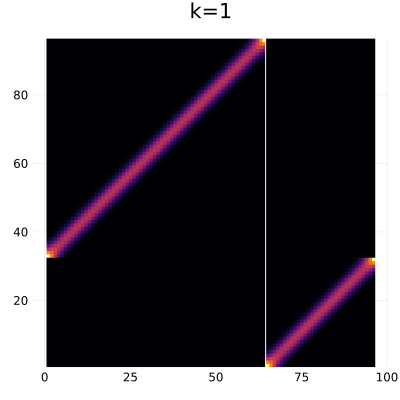

In [30]:
# Convert plan to dense matrix
A = plan_to_dense_matrix(P, c)
# Plot plan, and show limit of partitions in this iteration
p1 = heatmap(A, title = "k=1")
vline!([2n.+0.5], color = :white)

Perform a second iteration on the subdomains of the other partition, leaving their Y-marginals fixed:

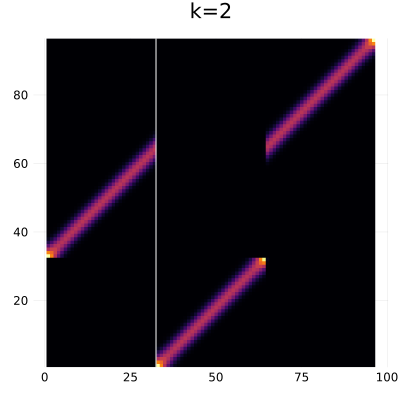

In [31]:
iterate_serial!(P, 2, c, solver, params)
A = plan_to_dense_matrix(P, c)
p2 = heatmap(A, title = "k=2")
vline!([n.+0.5], color = :white)

Perform a third iteration and show all of them

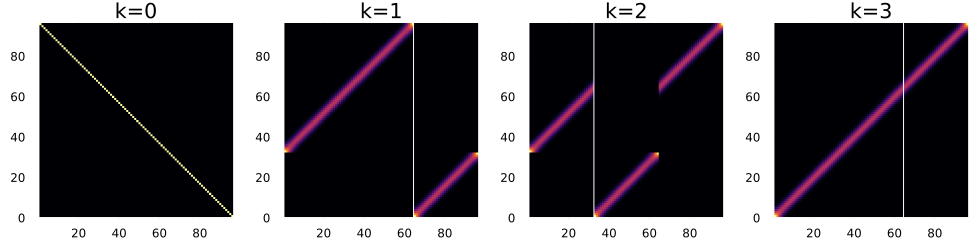

In [32]:
iterate_serial!(P, 3, c, solver, params)
A = plan_to_dense_matrix(P, c)
p3 = heatmap(A, title = "k=3")
vline!([2n.+0.5], color = :white)
plot(p0, p1, p2, p3, layout = (1,4), size = (980, 240))

We needed 3 iterations to obtain a plan that resembles the optimal solution. In fact, if we run the domain decomposition on a fixed resolution, we observe that we need approximately a number of iterations proportional to the number of basic cells to converge to the optimal solution (for the relation of domain decomposition with parallel bubble sort see Section 5 of https://arxiv.org/abs/2001.10986). This means that, if we run a coarse-to-fine scheme, where the last iterate at a coarser level serves as initialization to the finer one, we need a number of iterations that is _logarithmic_ in the size of the finest problem (assuming the cellsize is constant). We will explore this in the next notebook. 

As a last check up, let us evolution of the primal-dual gap as we keep iteration the domain decomposition algorithm. For this we start with a freshly copied plan `P`, 

In [33]:
P = deepcopy(P0)
println("Iter.\tRelative PD gap")
for i in 1:10
    iterate_serial!(P, i, c, solver, params)
    A = plan_to_dense_matrix(P, c)
    a, b = smooth_alpha_and_beta_fields(P, c)
    s1 = primal_score_dense(A, c, nu, mu, P.epsilon)
    s2 = dual_score_dense(b, a, c, nu, mu, P.epsilon)
    println(i,"\t",(s1-s2)/s1)
end

Iter.	Relative PD gap
1	Inf
2	1.4685761177477217e66
3	7.782910571633858e43
4	0.0017055116095549383
5	0.0025816063860355084
6	0.0012902417826454328
7	0.002050018676764513
8	0.0009827350593915793
9	0.0016363003332709695
10	0.000768886340766128
